In [1]:
from __future__ import absolute_import, division, print_function
import os, sys, pdb, pickle
from multiprocessing import Process, Pool
import time
# from sets import Set

import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as sig
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn.functional as F
import torch.nn as nn

os.environ['CUDA_VISIBLE_DEVICES']='3'

from jupyterthemes import jtplot
jtplot.style()

In [7]:
data_folder = '../outfiles/'
data_version = 'processed-12_mel_noiseless_8bit_quant_env_12p8rms'

with open(data_folder + data_version + '_ys.pkl', 'rb') as f:
    (ytr, yva, yte, classes) = pickle.load(f)
    num_classes = len(classes)
with open(data_folder + data_version + '_Xte.npy', 'rb') as f:
    Xte = np.load(f)
with open(data_folder + data_version + '_Xva.npy', 'rb') as f:
    Xva = np.load(f)
with open(data_folder + data_version + '_Xtr.npy', 'rb') as f:
    Xtr = np.load(f)
print(Xtr.shape,Xva.shape,Xte.shape,ytr.shape,yva.shape,yte.shape)

mu = np.mean(Xtr, 0)
std = np.std(Xtr, 0)
Xtr = ((Xtr - mu) / std)
Xva = ((Xva - mu) / std)
Xte = ((Xte - mu) / std)

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]
Ytr = to_categorical(ytr, num_classes)
Yva = to_categorical(yva, num_classes)
Yte = to_categorical(yte, num_classes)

(21981, 32, 96) (3069, 32, 96) (3031, 32, 96) (21981,) (3069,) (3031,)


In [8]:
def metrics(pte):
    conf_te = confusion_matrix(yte, pte)

    # https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, (ax1, ax2, axc) = plt.subplots(1,3,figsize=(18, 6))

    ax1.plot(range(epochs), hist['TrLoss'], 'ro-', label='Training')
    ax1.plot(range(epochs), hist['VaLoss'], 'bo-', label='Validation')
    ax1.legend()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    ax2.plot(range(epochs), hist['TrAcc'], 'ro-', label='Training')
    ax2.plot(range(epochs), hist['VaAcc'], 'bo-', label='Validation')
    ax2.legend()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy')

    im = axc.imshow(np.log(1 + conf_te), cmap='jet')
    axc.set_xticks(range(num_classes))
    axc.set_yticks(range(num_classes))
    axc.set_xticklabels(classes)
    axc.set_yticklabels(classes)
    plt.setp(axc.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for i in range(num_classes):
        for j in range(num_classes):
            text = axc.text(j,i,conf_te[i,j], ha='center', va='center', color='w')
    axc.set_title('Confusion Matrix')
    axc.grid(False)

    fig.tight_layout()
    plt.show()

In [9]:
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)

class Quantize(nn.Module):
    def __init__(self):
        super(Quantize, self).__init__()
    
    def forward(self, x):
        return x

class StochasticDropout(nn.Module):
    def __init__(self, sigma):
        super(StochasticDropout, self).__init__()
        self.sigma = sigma
        
    def forward(self, x):
        if self.training: sdo = torch.from_numpy(np.exp(np.random.normal(loc=-self.sigma**2/2, scale=self.sigma, size=list(x.size()))).astype('f')).cuda()
        else: sdo = 1
        return x * sdo

class ResLayer(nn.Module):
    def __init__(self, in_channels, out_channels, momentum=0.05, maxpool=False):
        super(ResLayer, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.maxpool = maxpool
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), padding=(0,0), bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=(1,1), bias=True)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=(1,1), bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=momentum)
    
    def forward(self, x):
        x = self.conv1(x)
        xi = x
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.bn1(x + xi)
        x = F.relu(x)
        if self.maxpool: x = F.max_pool2d(x, 2, 2)
        return x

class HardSigmoid(nn.Module):
    def __init__(self):
        super(HardSigmoid, self).__init__()
    
    def forward(self, x):
        return (torch.clamp(x, min=-2.5, max=2.5) + 2.5) / 5.0

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class liGRU(nn.Module):
    def __init__(self, units, inp_dim, use_cuda=True):
        super(liGRU, self).__init__()
        
        # Parameters
        self.input_dim = inp_dim
        self.ligru_lay = [units]
        self.drop = {
            'in': ('binomial', 0.2),
            'orig': ('binomial', 0.2),
            'recur': ('binomial', 0.2),
        }
        self.ligru_use_batchnorm_inp = False
        self.ligru_use_laynorm_inp = False
        self.ligru_use_batchnorm = [True]
        self.ligru_use_laynorm = [False]
        self.ligru_orthinit = True
        self.bidir = False
        self.use_cuda = use_cuda
        #self.mode = mode
        #self.test_flag = (self.mode != 'train')
        
        # List initialization
        self.wh = nn.ModuleList([])
        self.uh = nn.ModuleList([])
        self.wz = nn.ModuleList([])
        self.uz = nn.ModuleList([])

        self.ln = nn.ModuleList([]) # Layer Norm
        self.bn_wh = nn.ModuleList([]) # Batch Norm
        self.bn_wz = nn.ModuleList([]) # Batch Norm
        if self.ligru_use_laynorm_inp: self.ln0 = LayerNorm(self.input_dim) # Input layer normalization
        if self.ligru_use_batchnorm_inp: self.bn0 = nn.BatchNorm1d(self.input_dim, momentum = 0.05) # Input batch normalization
        
        self.N_ligru_lay = len(self.ligru_lay)
        current_input = self.input_dim
        
        # Initialization of hidden layers
        for i in range(self.N_ligru_lay):
            add_bias = True
            if self.ligru_use_laynorm[i] or self.ligru_use_batchnorm[i]: add_bias = False
            
            # Feed-forward connections
            self.wh.append(nn.Linear(current_input, self.ligru_lay[i], bias = add_bias))
            self.wz.append(nn.Linear(current_input, self.ligru_lay[i], bias = add_bias))
            # Recurrent connections
            self.uh.append(nn.Linear(self.ligru_lay[i], self.ligru_lay[i], bias = False))
            self.uz.append(nn.Linear(self.ligru_lay[i], self.ligru_lay[i], bias = False))

            if self.ligru_orthinit:
                nn.init.orthogonal_(self.uh[i].weight)
                nn.init.orthogonal_(self.uz[i].weight)
            
            # batch norm initialization
            self.bn_wh.append(nn.BatchNorm1d(self.ligru_lay[i], momentum = 0.05))
            self.bn_wz.append(nn.BatchNorm1d(self.ligru_lay[i], momentum = 0.05))
            self.ln.append(LayerNorm(self.ligru_lay[i]))
            
            if self.bidir: current_input = 2 * self.ligru_lay[i]
            else: current_input = self.ligru_lay[i]
        self.out_dim = self.ligru_lay[i] + self.bidir * self.ligru_lay[i]
    
    def forward(self, x):
        # Applying Layer/Batch Norm
        if bool(self.ligru_use_laynorm_inp): x = self.ln0((x))
        if bool(self.ligru_use_batchnorm_inp):
            x_bn = self.bn0(x.view(x.shape[0] * x.shape[1], x.shape[2]))
            x = x_bn.view(x.shape[0], x.shape[1], x.shape[2])
        
        for i in range(self.N_ligru_lay):
            # Initial state and concatenation
            if self.bidir:
                h_init = torch.zeros(2*x.shape[1], self.ligru_lay[i])
                x = torch.cat([x,flip(x,0)], 1)
            else:
                h_init = torch.zeros(x.shape[1], self.ligru_lay[i])
            
            # Drop mask initilization (same mask for all time steps)
            in_size = [1]+list(x.size())[1:]
            h_size = list(h_init.size()[:2])
            if self.drop['in'][0] == 'stochastic':
                sigma = self.drop['in'][1]
                drop_mask_ih = torch.from_numpy(np.exp(np.random.normal(loc=-sigma**2/2, scale=sigma, size=in_size)).astype('f')) if self.training else torch.FloatTensor([1])
                drop_mask_iz = torch.from_numpy(np.exp(np.random.normal(loc=-sigma**2/2, scale=sigma, size=in_size)).astype('f')) if self.training else torch.FloatTensor([1])
            else:
                prob = self.drop['in'][1]
                drop_mask_ih = torch.bernoulli(torch.Tensor(*in_size).fill_(1-prob)) if self.training else torch.FloatTensor([1-prob])
                drop_mask_iz = torch.bernoulli(torch.Tensor(*in_size).fill_(1-prob)) if self.training else torch.FloatTensor([1-prob])
            if self.drop['recur'][0] == 'stochastic':
                sigma = self.drop['recur'][1]
                drop_mask_rh = torch.from_numpy(np.exp(np.random.normal(loc=-sigma**2/2, scale=sigma, size=h_size)).astype('f')) if self.training else torch.FloatTensor([1])
                drop_mask_rz = torch.from_numpy(np.exp(np.random.normal(loc=-sigma**2/2, scale=sigma, size=h_size)).astype('f')) if self.training else torch.FloatTensor([1])
            else:
                prob = self.drop['recur'][1]
                drop_mask_rh = torch.bernoulli(torch.Tensor(*h_size).fill_(1-prob)) if self.training else torch.FloatTensor([1-prob])
                drop_mask_rz = torch.bernoulli(torch.Tensor(*h_size).fill_(1-prob)) if self.training else torch.FloatTensor([1-prob])
            if self.drop['orig'][0] == 'stochastic':
                sigma = self.drop['orig'][1]
                drop_mask_o = torch.from_numpy(np.exp(np.random.normal(loc=-sigma**2/2, scale=sigma, size=h_size)).astype('f')) if self.training else torch.FloatTensor([1])
            else:
                prob = self.drop['orig'][1]
                drop_mask_o = torch.bernoulli(torch.Tensor(*h_size).fill_(1-prob)) if self.training else torch.FloatTensor([1-prob])
                
            if self.use_cuda:
                h_init = h_init.cuda()
                drop_mask_ih = drop_mask_ih.cuda()
                drop_mask_iz = drop_mask_ih.cuda()
                drop_mask_rh = drop_mask_rh.cuda()
                drop_mask_rz = drop_mask_rz.cuda()
                drop_mask_o = drop_mask_o.cuda()
            
            # Feed-forward affine transformations (all steps in parallel)
            wh_out = self.wh[i](x * drop_mask_ih)
            wz_out = self.wz[i](x * drop_mask_iz)

            # Apply batch norm if needed (all steos in parallel)
            if self.ligru_use_batchnorm[i]:
                wh_out_bn = self.bn_wh[i](wh_out.view(wh_out.shape[0] * wh_out.shape[1], wh_out.shape[2]))
                wh_out = wh_out_bn.view(wh_out.shape[0], wh_out.shape[1], wh_out.shape[2])
                wz_out_bn = self.bn_wz[i](wz_out.view(wz_out.shape[0] * wz_out.shape[1], wz_out.shape[2]))
                wz_out = wz_out_bn.view(wz_out.shape[0], wz_out.shape[1], wz_out.shape[2])

            # Processing time steps
            hiddens = []
            ht = h_init
            for k in range(x.shape[0]):
                # ligru equation
                zt = torch.sigmoid(wz_out[k] + self.uz[i](ht * drop_mask_rz))
                #zt = HardSigmoid()(wz_out[k] + self.uz[i](ht * rdrop_mask1))
                at = wh_out[k] + self.uh[i](ht * drop_mask_rh)
                hcand = F.relu(at) * drop_mask_o
                ht = (zt * ht + (1-zt) * hcand)
                
                if self.ligru_use_laynorm[i]: ht = self.ln[i](ht)
                hiddens.append(ht)
            h = torch.stack(hiddens)
            
            # Bidirectional concatenations
            if self.bidir:
                h_f = h[:,0:int(x.shape[1]/2)]
                h_b = flip(h[:,int(x.shape[1]/2):x.shape[1]].contiguous(),0)
                h = torch.cat([h_f,h_b],2)
            
            # Setup x for the next hidden layer
            x = h
        return x

In [10]:
class Net(nn.Module):
    def __init__(self, in_shape):
        super(Net, self).__init__()
        
        self.in_shape = in_shape
        self.oc = 128
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.oc, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=True)
        self.res1 = ResLayer(in_channels= 1, out_channels=32, momentum=0.05, maxpool=True)
        self.res2 = ResLayer(in_channels=32, out_channels=64, momentum=0.05, maxpool=True)
        self.res3 = ResLayer(in_channels=64, out_channels=self.oc, momentum=0.05, maxpool=False)
        self.recur1 = liGRU(32, self.oc * self.in_shape[0]//4, use_cuda=True)
        # self.fc1 = nn.Linear(256, 256)
        # self.sdo = StochasticDropout(0.5)
        self.fc2 = nn.Linear(32, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        #x = F.relu(self.conv1(x))
        x = self.res3(self.res2(self.res1(x)))
        # x = self.res3(self.res2(x))
        x = x.view(-1, self.oc * self.in_shape[0]//4, self.in_shape[1]//4).permute(2, 0, 1).contiguous()
        x = self.recur1(x)[-1]
        #x = x.permute(1,0,2).contiguous().view(-1,96*512) # for bidirectional
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        #x = self.sdo(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

/home/danvilla/anaconda2/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/danvilla/anaconda2/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 001/100 - Step 022/022 (100.0%) - LR 9.80e-04 - TrLoss 2.2900 - TrAcc 0.1979 - VaLoss 2.3019 - VaAcc 0.2434 - Time 13.5s *
Epoch 002/100 - Step 022/022 (100.0%) - LR 9.60e-04 - TrLoss 1.9309 - TrAcc 0.3371 - VaLoss 1.7358 - VaAcc 0.4715 - Time 13.7s *
Epoch 003/100 - Step 022/022 (100.0%) - LR 9.41e-04 - TrLoss 1.6012 - TrAcc 0.4488 - VaLoss 1.2879 - VaAcc 0.5885 - Time 13.9s *
Epoch 004/100 - Step 022/022 (100.0%) - LR 9.22e-04 - TrLoss 1.3059 - TrAcc 0.5573 - VaLoss 1.0732 - VaAcc 0.6527 - Time 13.6s *
Epoch 005/100 - Step 022/022 (100.0%) - LR 9.04e-04 - TrLoss 1.1372 - TrAcc 0.6186 - VaLoss 0.8901 - VaAcc 0.7276 - Time 14.2s *
Epoch 006/100 - Step 022/022 (100.0%) - LR 8.86e-04 - TrLoss 0.9668 - TrAcc 0.6821 - VaLoss 0.7228 - VaAcc 0.7833 - Time 13.5s *
Epoch 007/100 - Step 022/022 (100.0%) - LR 8.68e-04 - TrLoss 0.8462 - TrAcc 0.7250 - VaLoss 0.6852 - VaAcc 0.8117 - Time 13.8s *
Epoch 008/100 - Step 022/022 (100.0%) - LR 8.51e-04 - TrLoss 0.7541 - TrAcc 0.7704 - VaLoss 0.609

Epoch 065/100 - Step 022/022 (100.0%) - LR 2.69e-04 - TrLoss 0.1492 - TrAcc 0.9581 - VaLoss 0.2130 - VaAcc 0.9378 - Time 13.9s 
Epoch 066/100 - Step 022/022 (100.0%) - LR 2.64e-04 - TrLoss 0.1367 - TrAcc 0.9616 - VaLoss 0.2028 - VaAcc 0.9423 - Time 14.0s 
Epoch 067/100 - Step 022/022 (100.0%) - LR 2.58e-04 - TrLoss 0.1370 - TrAcc 0.9612 - VaLoss 0.2116 - VaAcc 0.9407 - Time 13.7s 
Epoch 068/100 - Step 022/022 (100.0%) - LR 2.53e-04 - TrLoss 0.1347 - TrAcc 0.9627 - VaLoss 0.1982 - VaAcc 0.9440 - Time 13.8s 
Epoch 069/100 - Step 022/022 (100.0%) - LR 2.48e-04 - TrLoss 0.1319 - TrAcc 0.9647 - VaLoss 0.1983 - VaAcc 0.9459 - Time 13.5s 
Epoch 070/100 - Step 022/022 (100.0%) - LR 2.43e-04 - TrLoss 0.1205 - TrAcc 0.9671 - VaLoss 0.2101 - VaAcc 0.9427 - Time 13.9s 
Epoch 071/100 - Step 022/022 (100.0%) - LR 2.38e-04 - TrLoss 0.1283 - TrAcc 0.9636 - VaLoss 0.2028 - VaAcc 0.9440 - Time 13.8s 
Epoch 072/100 - Step 022/022 (100.0%) - LR 2.33e-04 - TrLoss 0.1257 - TrAcc 0.9651 - VaLoss 0.1951 - VaA

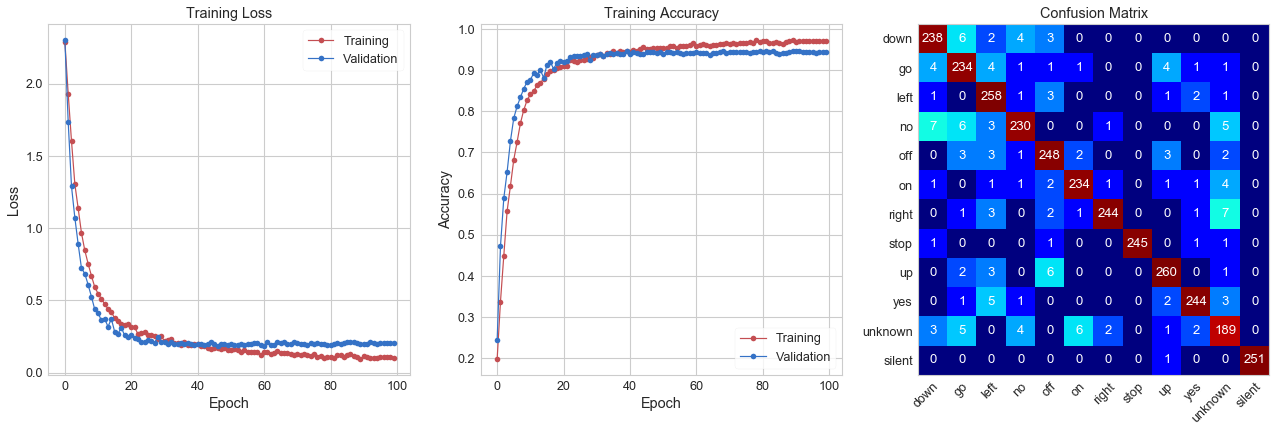

In [11]:
epochs = 100
batch_size = 1024
iters  = (Xtr.shape[0] + batch_size - 1) // batch_size
device = torch.device('cuda')

v = 17
model_F_file = 'models/F%03d.pt'%v

lr = 1e-3
model = Net(Xtr.shape[1:]).to(device)
obj = nn.CrossEntropyLoss(reduction='sum')
opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lambda epoch: 0.98 ** epoch)

def run_eval(Xev, yev):
    yp = []
    cur_loss = 0
    cur_acc  = 0
    model.eval()
    for step in range((Xev.shape[0] + batch_size - 1) // batch_size):
        x = torch.from_numpy(Xev[step * batch_size : (step + 1) * batch_size]).float().to(device)
        y = torch.from_numpy(yev[step * batch_size : (step + 1) * batch_size]).to(device)
        with torch.no_grad():
            y_pred = model(x)
        yp.append(y_pred.cpu().numpy())
        cur_loss += obj(y_pred, y).item()
        cur_acc  += np.sum((y_pred.max(dim=1)[1] == y).cpu().numpy())
    return np.argmax(np.vstack(yp), -1), cur_loss / Xev.shape[0], cur_acc / Xev.shape[0]

best_acc = 0
hist = {'TrLoss':[], 'TrAcc':[], 'VaLoss':[], 'VaAcc':[]}
for epoch in range(epochs):
    scheduler.step()
    cur_samp = 0
    cur_loss = 0
    cur_acc  = 0
    t0 = time.time()
    for step in range(iters):
        use = np.random.choice(range(Xtr.shape[0]), batch_size, replace=False)
        noise = np.random.uniform(0, 0.3) * np.random.randn(batch_size, *Xtr.shape[1:])
        noise += np.random.uniform(0, 0.3) * np.random.randn(batch_size, Xtr.shape[1], 1)
        x = torch.from_numpy(Xtr[use] + noise).float().to(device)
        y = torch.from_numpy(ytr[use]).to(device)
        
        model.train()
        y_pred = model(x)
        
        loss = obj(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        cur_samp += batch_size
        cur_loss += loss.item()
        cur_acc  += np.sum((y_pred.max(dim=1)[1] == y).cpu().numpy())
        lr = scheduler.get_lr()[-1]
        print('\rEpoch %03d/%03d - Step %03d/%03d (%5.1f%%) - LR %.2e - TrLoss %.4f - TrAcc %.4f'%(
            epoch+1, epochs, step+1, iters, 100*(step+1)/iters, lr, cur_loss / cur_samp, cur_acc / cur_samp), end='')
    
    _, loss, acc = run_eval(Xva, yva)
    if acc > best_acc:
        best_acc = acc
        cur_best = True
        torch.save(model.state_dict(), model_F_file)
    else:
        cur_best = False
    print(' - VaLoss %.4f - VaAcc %.4f - Time %4.1fs %s'%(loss, acc, time.time() - t0, '*' if cur_best else ''))
    hist['TrLoss'].append(cur_loss / cur_samp)
    hist['TrAcc' ].append(cur_acc / cur_samp)
    hist['VaLoss'].append(loss)
    hist['VaAcc' ].append(acc)


model.load_state_dict(torch.load(model_F_file))
pte, loss, acc = run_eval(Xte, yte)
print('TeLoss %.4f - TeAcc %.4f'%(loss, acc))

print()
print('Data version ---- %s'%data_version)
print('Saved in -------- %s'%model_F_file)
print('Results --------- F%.2f%% - T%.2f%%'%(100*best_acc, 100*acc))
metrics(pte)

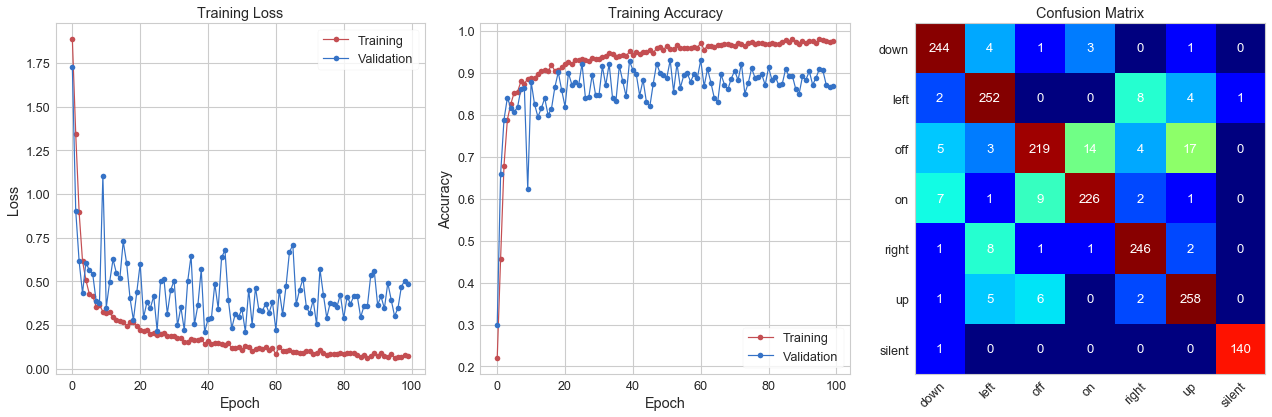

In [45]:
metrics(pte)

In [42]:
conf_te = confusion_matrix(yte, pte)

In [43]:
print(conf_te)

[[244   4   1   3   0   1   0]
 [  2 252   0   0   8   4   1]
 [  5   3 219  14   4  17   0]
 [  7   1   9 226   2   1   0]
 [  1   8   1   1 246   2   0]
 [  1   5   6   0   2 258   0]
 [  1   0   0   0   0   0 140]]


In [38]:
print(num_classes)

12


In [ ]:
with open(data_folder + data_version + '_submit.pkl', 'rb') as f:
    fnames = pickle.load(f)
with open(data_folder + data_version + '_Xsub.npy', 'rb') as f:
    Xsub = np.load(f)
Xsub = (Xsub - mu) / std

In [ ]:
psub = model.predict(Xsub)
preds = np.argmax(psub, -1)
pred_names = map(lambda x: classes[x], preds)
with open('submission-05.txt', 'w') as f:
    f.write('fname,label\n')
    for i in range(len(fnames)):
        f.write('%s,%s\n'%(fnames[i], pred_names[i]))

In [2]:
class liGRU(nn.Module):
    def __init__(self, units, inp_dim, use_cuda=False):
        super(liGRU, self).__init__()
        
        # Parameters
        self.input_dim = inp_dim
        self.ligru_lay = [units]
        self.ligru_drop = [0.1]
        self.ligru_rdrop = [0.1]
        self.sigma_do = 0.3
        self.sigma_dr = 0.3
        self.ligru_use_batchnorm_inp = False
        self.ligru_use_laynorm_inp = False
        self.ligru_use_batchnorm = [True]
        self.ligru_use_laynorm = [False]
        self.ligru_orthinit = True
        self.bidir = False
        self.use_cuda = use_cuda
        #self.mode = mode
        #self.test_flag = (self.mode != 'train')
        
        # List initialization
        self.wh = nn.ModuleList([])
        self.uh = nn.ModuleList([])
        self.wz = nn.ModuleList([])
        self.uz = nn.ModuleList([])

        self.ln = nn.ModuleList([]) # Layer Norm
        self.bn_wh = nn.ModuleList([]) # Batch Norm
        self.bn_wz = nn.ModuleList([]) # Batch Norm
        if self.ligru_use_laynorm_inp: self.ln0 = LayerNorm(self.input_dim) # Input layer normalization
        if self.ligru_use_batchnorm_inp: self.bn0 = nn.BatchNorm1d(self.input_dim, momentum = 0.05) # Input batch normalization
        
        self.N_ligru_lay = len(self.ligru_lay)
        current_input = self.input_dim
        
        # Initialization of hidden layers
        for i in range(self.N_ligru_lay):
            add_bias = True
            if self.ligru_use_laynorm[i] or self.ligru_use_batchnorm[i]: add_bias = False
            
            # Feed-forward connections
            self.wh.append(nn.Linear(current_input, self.ligru_lay[i], bias = add_bias))
            self.wz.append(nn.Linear(current_input, self.ligru_lay[i], bias = add_bias))
            # Recurrent connections
            self.uh.append(nn.Linear(self.ligru_lay[i], self.ligru_lay[i], bias = False))
            self.uz.append(nn.Linear(self.ligru_lay[i], self.ligru_lay[i], bias = False))

            if self.ligru_orthinit:
                nn.init.orthogonal_(self.uh[i].weight)
                nn.init.orthogonal_(self.uz[i].weight)
            
            # batch norm initialization
            self.bn_wh.append(nn.BatchNorm1d(self.ligru_lay[i], momentum = 0.05))
            self.bn_wz.append(nn.BatchNorm1d(self.ligru_lay[i], momentum = 0.05))
            self.ln.append(LayerNorm(self.ligru_lay[i]))
            
            if self.bidir: current_input = 2 * self.ligru_lay[i]
            else: current_input = self.ligru_lay[i]
        self.out_dim = self.ligru_lay[i] + self.bidir * self.ligru_lay[i]
    
    def forward(self, x):
        # Applying Layer/Batch Norm
        if bool(self.ligru_use_laynorm_inp): x = self.ln0((x))
        if bool(self.ligru_use_batchnorm_inp):
            x_bn = self.bn0(x.view(x.shape[0] * x.shape[1], x.shape[2]))
            x = x_bn.view(x.shape[0], x.shape[1], x.shape[2])
        
        for i in range(self.N_ligru_lay):
            # Initial state and concatenation
            if self.bidir:
                h_init = torch.zeros(2*x.shape[1], self.ligru_lay[i])
                x = torch.cat([x,flip(x,0)], 1)
            else:
                h_init = torch.zeros(x.shape[1], self.ligru_lay[i])
            
            # Drop mask initilization (same mask for all time steps)            
            if self.training:
                #drop_mask   = torch.bernoulli(torch.Tensor(h_init.shape[0],h_init.shape[1]).fill_(1-self.ligru_drop[i]))
                #rdrop_mask1 = torch.bernoulli(torch.Tensor(h_init.shape[0],h_init.shape[1]).fill_(1-self.ligru_rdrop[i]))
                #rdrop_mask2 = torch.bernoulli(torch.Tensor(h_init.shape[0],h_init.shape[1]).fill_(1-self.ligru_rdrop[i]))
                drop_mask = torch.from_numpy(np.exp(np.random.normal(loc=-self.sigma_do**2/2, scale=self.sigma_do, size=list(h_init.size()[:2]))).astype('f'))
                rdrop_mask1 = torch.from_numpy(np.exp(np.random.normal(loc=-self.sigma_dr**2/2, scale=self.sigma_dr, size=list(h_init.size()[:2]))).astype('f'))
                rdrop_mask2 = torch.from_numpy(np.exp(np.random.normal(loc=-self.sigma_dr**2/2, scale=self.sigma_dr, size=list(h_init.size()[:2]))).astype('f'))
            else:
                #drop_mask   = torch.FloatTensor([1-self.ligru_drop[i]])
                #rdrop_mask1 = torch.FloatTensor([1-self.ligru_rdrop[i]])
                #rdrop_mask2 = torch.FloatTensor([1-self.ligru_rdrop[i]])
                drop_mask   = torch.FloatTensor([1])
                rdrop_mask1 = torch.FloatTensor([1])
                rdrop_mask2 = torch.FloatTensor([1])
                
            if self.use_cuda:
                h_init = h_init.cuda()
                drop_mask = drop_mask.cuda()
                rdrop_mask1 = rdrop_mask1.cuda()
                rdrop_mask2 = rdrop_mask2.cuda()
            
            # Feed-forward affine transformations (all steps in parallel)
            wh_out = self.wh[i](x)
            wz_out = self.wz[i](x)

            # Apply batch norm if needed (all steos in parallel)
            if self.ligru_use_batchnorm[i]:
                wh_out_bn = self.bn_wh[i](wh_out.view(wh_out.shape[0] * wh_out.shape[1], wh_out.shape[2]))
                wh_out = wh_out_bn.view(wh_out.shape[0], wh_out.shape[1], wh_out.shape[2])
                wz_out_bn = self.bn_wz[i](wz_out.view(wz_out.shape[0] * wz_out.shape[1], wz_out.shape[2]))
                wz_out = wz_out_bn.view(wz_out.shape[0], wz_out.shape[1], wz_out.shape[2])

            # Processing time steps
            hiddens = []
            ht = h_init
            for k in range(x.shape[0]):
                # ligru equation
                zt = torch.sigmoid(wz_out[k] + self.uz[i](ht * rdrop_mask1))
                #zt = HardSigmoid()(wz_out[k] + self.uz[i](ht * rdrop_mask1))
                at = wh_out[k] + self.uh[i](ht * rdrop_mask2)
                hcand = F.relu(at) * drop_mask
                ht = (zt * ht + (1-zt) * hcand)
                
                if self.ligru_use_laynorm[i]: ht = self.ln[i](ht)
                hiddens.append(ht)
            h = torch.stack(hiddens)
            
            # Bidirectional concatenations
            if self.bidir:
                h_f = h[:,0:int(x.shape[1]/2)]
                h_b = flip(h[:,int(x.shape[1]/2):x.shape[1]].contiguous(),0)
                h = torch.cat([h_f,h_b],2)
            
            # Setup x for the next hidden layer
            x = h
        return x

NameError: name 'nn' is not defined